In [1]:
import os
import pyproj
import geopandas as gpd
import rasterio as rio
from shapely.geometry import box
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
gpd.__version__

'0.13.0'

### Step 01:

    a. Load Boundary data
    b. cut the boundary geometry into 20 m x 20 m box
    

In [3]:
def subset_geom(path: str, crs: pyproj.crs.crs.CRS = 'epsg:3763', grid_resolution: int = 20):
    """generate resolution grid_res x grid_rs
    
    Parameters
    ----------
        :path
        :crs
    
    Return 
    ------
    
    """
    # Load the two GeoDataFrames
    gpd_df = gpd.read_file(path)
    original_crs = gpd_df.crs
    
    # convert degrees to meter
    gpd_df = gpd_df.to_crs(crs)

    # Get the bounding box of the shapefile
    xmin, ymin, xmax, ymax = gpd_df.total_bounds
    
    # Calculate the number of rows and columns in the grid based on the resolution
    num_cols = int((xmax - xmin) / grid_resolution)
    num_rows = int((ymax - ymin) / grid_resolution)
    
    # Generate a grid of polygons within the bounding box
    polygons = []
    for row in range(num_rows+2):
        for col in range(num_cols+2):
            x1 = xmin + col * grid_resolution
            y1 = ymin + row * grid_resolution
            x2 = x1 + grid_resolution
            y2 = y1 + grid_resolution
            polygons.append(box(x1, y1, x2, y2))
            
    # Create a GeoDataFrame from the list of polygons
    return gpd.GeoDataFrame(geometry=polygons, crs=crs).to_crs(original_crs)

In [22]:
boundary_path = '../446032/BOUNDARY1015-Rt49_Williams_E80.zip'
gdf1 = subset_geom(boundary_path)

In [5]:
# # Load the two GeoDataFrames
# gpd_df = gpd.read_file('./445735/BOUNDARY1027-Rt49_Glick_80.zip')

# # convert degrees to meter
# gpd_df = gpd_df.to_crs(epsg=3763)

# # Get the bounding box of the shapefile
# xmin, ymin, xmax, ymax = gpd_df.total_bounds

# # Define the grid resolution in meters
# grid_resolution = 20

# # Calculate the number of rows and columns in the grid based on the resolution
# num_cols = int((xmax - xmin) / grid_resolution)
# num_rows = int((ymax - ymin) / grid_resolution)

# # Generate a grid of polygons within the bounding box
# polygons = []
# for row in range(num_rows+2):
#     for col in range(num_cols+2):
#         x1 = xmin + col * grid_resolution
#         y1 = ymin + row * grid_resolution
#         x2 = x1 + grid_resolution
#         y2 = y1 + grid_resolution
#         polygons.append(box(x1, y1, x2, y2))
        
# # Create a GeoDataFrame from the list of polygons
# gdf1 = gpd.GeoDataFrame(geometry=polygons, crs='epsg:3763')
# gdf1 = gdf1.to_crs('epsg:4326')        

In [11]:
type(gdf1.crs)

pyproj.crs.crs.CRS

<Axes: >

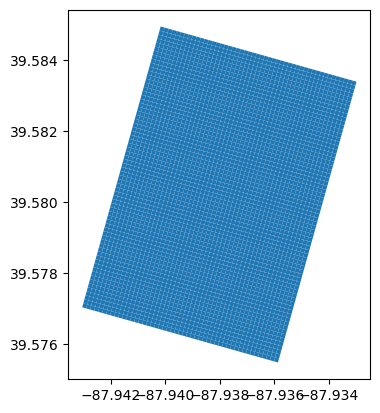

In [12]:
gdf1.plot()

In [13]:
gdf1.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Step 02

    a. load yield data
    b. get geometry from overlap - intersection
    c. count each geometry area
    d. set filter to filter out the area is larger than area threshold, which is based on **area_mean - area_std**.
    

In [14]:
def clip_with_harvest(geom, yield_path, MinAreaPercentage = 0.6):
    yield_df = gpd.read_file(yield_path)

    # Initialize an empty GeoDataFrame to store the intersections meeting the condition
    valid_geom = 1, []    
    for num, (idx, row) in enumerate(geom.iterrows()):
        # Step 1: Create a GeoDataFrame for each row
        row_gdf = gpd.GeoDataFrame(row.to_frame().T, geometry='geometry', crs = yield_df.crs)
        
        # Step 2: Perform the intersection operation with gdf2
        intersection = gpd.overlay(row_gdf, yield_df, how='intersection')

        # Step 4: Calculate the area of the intersection
        intersection['area'] = intersection.to_crs('epsg:3763').area

        # Step 5: filter out the 20 m x 20 m box if area of the intersection 
        #         ratio is larger than MinAreaPercentage
        if intersection['area'].sum()/400. > MinAreaPercentage:
            valid_geom.append(row)

    if len(valid_geom) == 0: 
        raise ValueError({
            'status': 'failed', 
            'reason': 'no overlap, please check th', 
        })
    valid_geom = pd.concat(valid_geom)
        
    valid_geom = valid_geom.reset_index().drop('index',axis=1).rename(columns={0:'geometry'})
    valid_geom_gdf = gpd.GeoDataFrame(valid_geom, geometry = 'geometry',crs='epsg:4326')
        
    sjoin = gpd.sjoin(valid_geom_gdf, yield_df.to_crs('epsg:4326'), how='left', predicate='intersects').dropna()
    return sjoin.groupby('index_right').agg('first')

In [23]:
yield_data_path = '../446032/Equipment_Harvest/2022-10-28/8BR1C4R6B/harvest/186_master_debug.zip'
sjoin = clip_with_harvest(gdf1, yield_data_path)

AttributeError: 'tuple' object has no attribute 'append'

In [24]:
gdf2 = gpd.read_file(yield_data_path)
gdf2.to_crs('epsg:4326').iloc[:2].geometry

0    POLYGON ((-87.94006 39.57653, -87.94017 39.576...
1    POLYGON ((-87.94007 39.57653, -87.94017 39.576...
Name: geometry, dtype: geometry

In [25]:
#----------------- test ---------------
row_gdf = gpd.GeoDataFrame(gdf1.iloc[2000].to_frame().T, geometry='geometry', crs = gdf2.crs)
intersection = gpd.overlay(row_gdf, gdf2, how='intersection')
intersection['area'] = intersection.to_crs('epsg:3763').area
intersection['area'].sum()/400.

1.000030879836542

In [17]:
gdf2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
MinAreaPercentage = 0.6

# Initialize an empty GeoDataFrame to store the intersections meeting the condition
# valid_geometry = gpd.GeoDataFrame(columns=gdf1.columns)
count, valid_geometry = 1, []

for idx, row in gdf1.iterrows():
    # Step 1: Convert the shapely polygon into a GeoSeries
    row_geoseries = gpd.GeoSeries([row.geometry])

    # Step 2: Create a GeoDataFrame from the GeoSeries
    row_gdf = gpd.GeoDataFrame({'geometry': row_geoseries}, crs="epsg:4326")

    # Step 3: Perform the intersection operation with gdf2
    intersection = gpd.overlay(row_gdf, gdf2, how='intersection')

    # Step 4: Calculate the area of the intersection
    intersection['area'] = intersection.to_crs('epsg:3763').area

    # Step 5: filter out the 20 m x 20 m box if area of the intersection 
    #         ratio is larger than MinAreaPercentage
    if intersection['area'].sum()/400. > MinAreaPercentage:
        # valid_geometry = valid_geometry.append(row, ignore_index=True)
        valid_geometry.append(row)
    elif len(intersection) !=0:
        count+=1

print('filter out: count', count, gdf1.shape)


filter out: count 133 (3430, 1)


<Axes: >

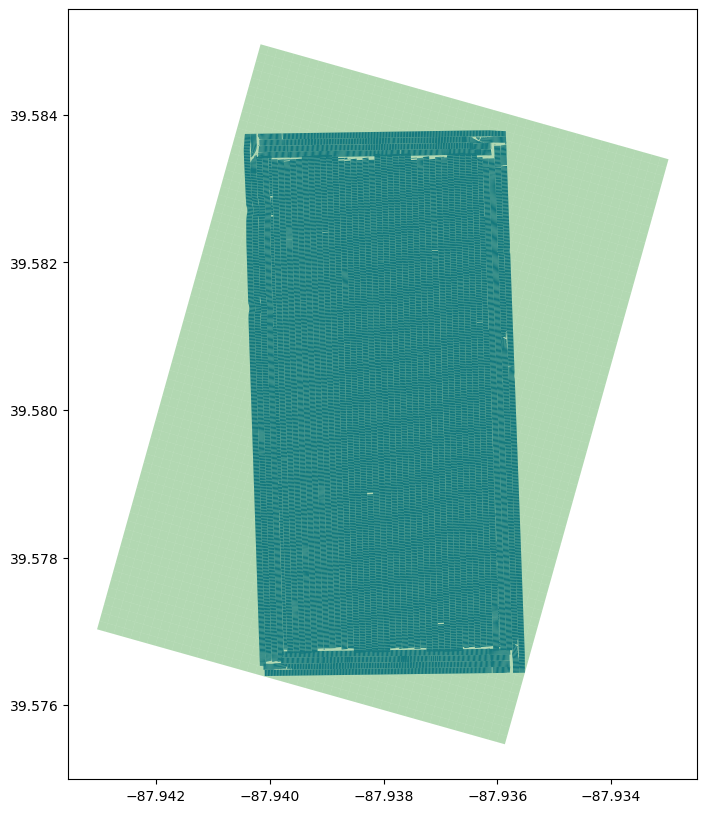

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
gdf2.plot(ax=ax)
gdf1.plot(ax=ax, alpha=0.3, color='g')


In [28]:
import pandas as pd
valid_geometry_df = pd.concat(valid_geometry)

In [29]:
valid_geometry_df = valid_geometry_df.reset_index().drop('index',axis=1).rename(columns={0:'geometry'})

In [30]:
valid_geometry_gdf = gpd.GeoDataFrame(valid_geometry_df, geometry = 'geometry',crs='epsg:4326')

In [31]:
valid_geometry_gdf['area'] = valid_geometry_gdf.to_crs('epsg:3763').area


In [32]:
valid_geometry_gdf.shape

(1889, 2)

<Axes: >

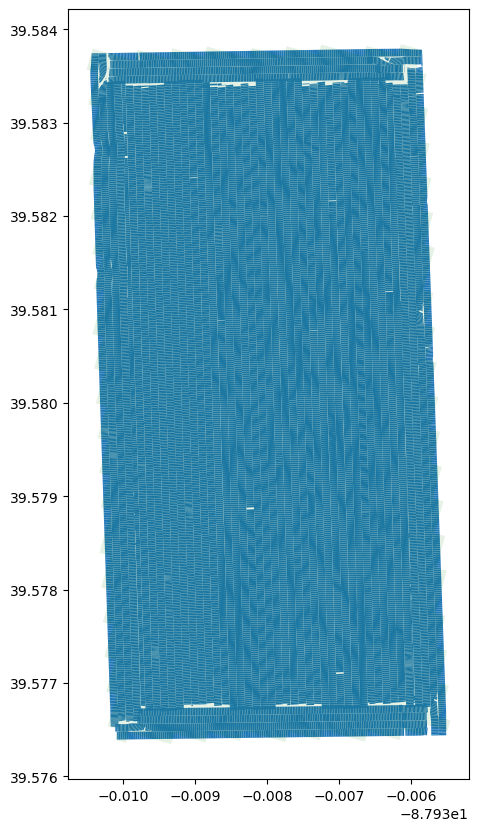

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
gdf2.plot(ax=ax)
valid_geometry_gdf.plot(ax=ax, alpha=0.1, color='g')

In [33]:
sjoin = gpd.sjoin(valid_geometry_gdf, gdf2.to_crs('epsg:4326'), how='left', predicate='intersects').dropna()
sjoin = sjoin.groupby('index_right').agg('first')

In [34]:
print(sjoin.shape)
sjoin.head()

(16728, 18)


,geometry,area,DISTANCE,SWATHWIDTH,BuPerAc,SECTIONID,Crop,WetMass,Moisture,Timestamp,Heading,VARIETY,Elevation,IsoTime,Machine,Speed,date,grouping
index_right,,,,,,,,,,,,,,,,,,
0,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,0.69,30.0,68.63,5798,Corn,3843.28,12.90,10/28/2022 12:20:13 AM,2.71,---,705.68,2022-10-28T00:20:13.418Z,1,1.04,2022-10-28,2022-10-28_Corn
1,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,1.53,30.0,170.21,5798,Corn,9531.38,12.90,10/28/2022 12:20:14 AM,1.22,---,705.67,2022-10-28T00:20:14.417Z,1,1.09,2022-10-28,2022-10-28_Corn
2,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,0.65,30.0,229.83,5798,Corn,12870.06,12.90,10/28/2022 12:20:14 AM,0.56,---,705.66,2022-10-28T00:20:14.822Z,1,0.97,2022-10-28,2022-10-28_Corn
3,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,1.41,30.0,265.08,5798,Corn,14843.96,12.93,10/28/2022 12:20:15 AM,359.42,Burrus 4C16,705.76,2022-10-28T00:20:15.818Z,1,1.67,2022-10-28,2022-10-28_Corn
4,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,2.44,30.0,229.47,5798,Corn,12849.46,13.00,10/28/2022 12:20:16 AM,359.92,Burrus 4C16,705.70,2022-10-28T00:20:16.817Z,1,1.96,2022-10-28,2022-10-28_Corn


<Axes: >

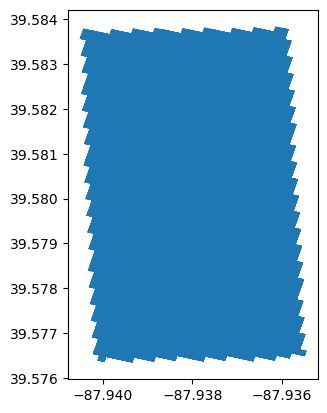

In [35]:
sjoin.plot()

In [36]:
sjoin.head()

,geometry,area,DISTANCE,SWATHWIDTH,BuPerAc,SECTIONID,Crop,WetMass,Moisture,Timestamp,Heading,VARIETY,Elevation,IsoTime,Machine,Speed,date,grouping
index_right,,,,,,,,,,,,,,,,,,
0,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,0.69,30.0,68.63,5798,Corn,3843.28,12.90,10/28/2022 12:20:13 AM,2.71,---,705.68,2022-10-28T00:20:13.418Z,1,1.04,2022-10-28,2022-10-28_Corn
1,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,1.53,30.0,170.21,5798,Corn,9531.38,12.90,10/28/2022 12:20:14 AM,1.22,---,705.67,2022-10-28T00:20:14.417Z,1,1.09,2022-10-28,2022-10-28_Corn
2,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,0.65,30.0,229.83,5798,Corn,12870.06,12.90,10/28/2022 12:20:14 AM,0.56,---,705.66,2022-10-28T00:20:14.822Z,1,0.97,2022-10-28,2022-10-28_Corn
3,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,1.41,30.0,265.08,5798,Corn,14843.96,12.93,10/28/2022 12:20:15 AM,359.42,Burrus 4C16,705.76,2022-10-28T00:20:15.818Z,1,1.67,2022-10-28,2022-10-28_Corn
4,"POLYGON ((-87.94003 39.57662, -87.94017 39.576...",400.0,2.44,30.0,229.47,5798,Corn,12849.46,13.00,10/28/2022 12:20:16 AM,359.92,Burrus 4C16,705.70,2022-10-28T00:20:16.817Z,1,1.96,2022-10-28,2022-10-28_Corn


### Shadow detection on Aeroptic Dataset.
 Functions

In [37]:
import numpy as np
import rioxarray as rx
import xarray as xr
from scipy.ndimage import gaussian_filter


def shadow_detection(filepath: str) -> xr.Dataset:
    # Load the raster image
    dataset = rx.open_rasterio(filepath)

    # Read the bands
    red_band = dataset.sel(band=1).astype(np.float32)
    green_band = dataset.sel(band=2).astype(np.float32)
    blue_band = dataset.sel(band=3).astype(np.float32)
    nir_band = dataset.sel(band=4).astype(np.float32)

    # Calculate NDVI
    ndvi = (nir_band - red_band) / (nir_band + red_band)

    # Set an NDVI threshold value for shadow detection (e.g., 0.1)
    shadow_threshold = 0.1

    # Identify shadow pixels
    shadow_pixels = ndvi < shadow_threshold

    # Apply a Gaussian filter to the non-shadow pixels of each band
    filtered_red = gaussian_filter(red_band, sigma=3)
    filtered_green = gaussian_filter(green_band, sigma=3)
    filtered_blue = gaussian_filter(blue_band, sigma=3)

    # Correct shadow pixels using the mean value of the surrounding pixels
    corrected_red = np.where(shadow_pixels, filtered_red, red_band)
    corrected_green = np.where(shadow_pixels, filtered_green, green_band)
    corrected_blue = np.where(shadow_pixels, filtered_blue, blue_band)

    # Create a new xarray DataArray for each corrected band
    corrected_red_da = dataset.sel(band=1).copy(data=corrected_red)
    corrected_green_da = dataset.sel(band=2).copy(data=corrected_green)
    corrected_blue_da = dataset.sel(band=3).copy(data=corrected_blue)

    # Replace the original bands with the corrected ones
    corrected_dataset = dataset.copy()
    corrected_dataset.loc[dict(band=1)] = corrected_red_da
    corrected_dataset.loc[dict(band=2)] = corrected_green_da
    corrected_dataset.loc[dict(band=3)] = corrected_blue_da

    return corrected_dataset



In [41]:
aeroptic_path = '../446032/Aeroptic/2022-06-23/2G84FPY6R/merged_out.tif'
aeroptic_df = shadow_detection(aeroptic_path)

In [42]:
aeroptic_df

<xarray.DataArray (band: 4, y: 1735, x: 933)>
[6475020 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.192e+05 4.192e+05 ... 4.197e+05 4.197e+05
  * y            (y) float64 4.382e+06 4.382e+06 ... 4.381e+06 4.381e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

### Step 4

    1. rio clip on aerial imagery data
    2. calculate the shadows 
    3. get 90th percential as reference at each band
    4. get relative value and take mean of it.


In [43]:
def relative_value_of_aerial(geom: gpd.GeoDataFrame, ds: xr.Dataset, percential: float):
    process = []
    for idx, row in geom.iterrows():
        row_gdf = gpd.GeoDataFrame(row.to_frame().T, geometry='geometry', crs = ds.rio.crs)
        clipped = ds.rio.clip(row_gdf.geometry.apply(lambda x: x.__geo_interface__), row_gdf.crs)
        
        ref = clipped.quantile(percential, dim=['x', 'y'])
        rlt = clipped/ref
        row_gdf['band1'], row_gdf['band2'], row_gdf['band3'], row_gdf['band4'] = zip(rlt.mean(dim=['x','y']).data)
        
        process.append(row_gdf)
        
    return pd.concat(process)
    

In [44]:
#- Aeroptic
#- shadow detection process
#aeroptic_path = './445735/Aeroptic/2022-06-23/WHZDBL1YC/merged_out.tif'
aeroptic_df = shadow_detection(aeroptic_path)


In [45]:
aeroptic_df

<xarray.DataArray (band: 4, y: 1735, x: 933)>
[6475020 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.192e+05 4.192e+05 ... 4.197e+05 4.197e+05
  * y            (y) float64 4.382e+06 4.382e+06 ... 4.381e+06 4.381e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

NameError: name 'aeropic_df_concat' is not defined

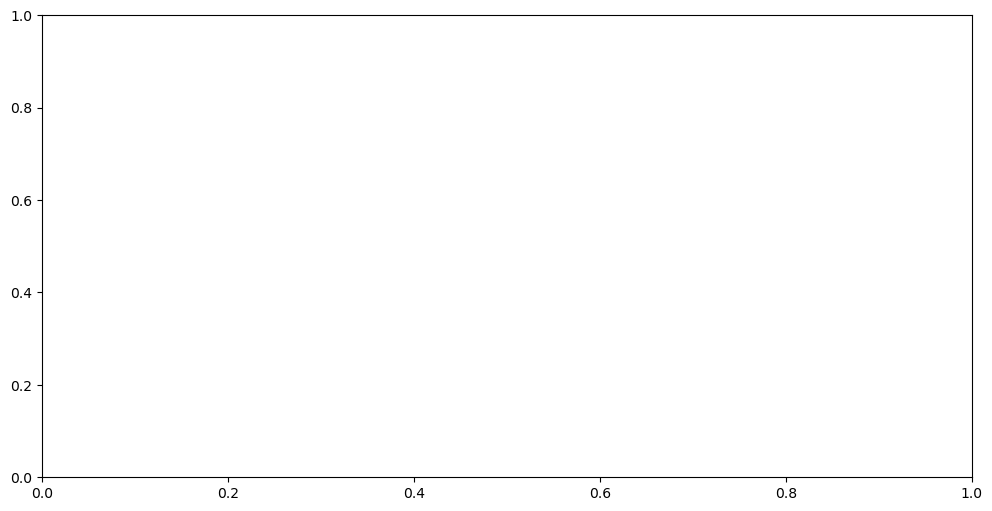

In [46]:
fig, ax = plt.subplots(figsize=(12,6))

aeropic_df_concat.plot(ax=ax, alpha=0.1, color='green')
aeroptic_df.isel(band=1).plot(ax=ax, alpha=0.8)

In [463]:
print(aeroptic_df.rio.crs, '\n\n\n', aeropic_df_concat.crs)

EPSG:32616 


 PROJCS["WGS 84 / UTM zone 16N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32616"]]


In [465]:
aeropic_df_concat.to_crs('epsg:4326').to_csv('aeropic_df_test.csv')

In [446]:
print(sjoin.geometry.iloc[0])

POLYGON ((419585.448776448 4387222.947926547, 419572.9012894116 4387226.608834669, 419569.24040050246 4387214.061357821, 419581.7878581347 4387210.400458725, 419585.448776448 4387222.947926547))


In [448]:
aeroptic_df.x.data.min(), aeroptic_df.x.data.max()

(418777.6019567001, 419613.6019567001)

In [449]:
aeroptic_df.y.data.min(), aeroptic_df.y.data.max()

(4386834.7315691225, 4387287.2315691225)

In [451]:
print(aeropic_df_concat.geometry.iloc[0])

POLYGON ((419585.448776448 4387222.947926547, 419572.9012894116 4387226.608834669, 419569.24040050246 4387214.061357821, 419581.7878581347 4387210.400458725, 419585.448776448 4387222.947926547))


In [47]:
#- relative value 
aeropic_df_concat = relative_value_of_aerial(sjoin, aeroptic_df, 0.9)

NoDataInBounds: No data found in bounds.

In [421]:
aeropic_df_concat.head()

,geometry,area,DISTANCE,SWATHWIDTH,BuPerAc,SECTIONID,Crop,WetMass,Moisture,Timestamp,...,Elevation,IsoTime,Machine,Speed,date,grouping,band1,band2,band3,band4
2,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,1.98,30.0,199.34,22089,Corn,11162.5,14.8,11/4/2022 4:52:42 PM,...,683.37,2022-11-04T16:52:42.118Z,1,1.77,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
3,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.58,30.0,203.61,22089,Corn,11401.77,14.8,11/4/2022 4:52:43 PM,...,683.41,2022-11-04T16:52:43.113Z,1,1.81,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
4,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.66,30.0,264.16,22089,Corn,14792.05,14.8,11/4/2022 4:52:44 PM,...,683.46,2022-11-04T16:52:44.113Z,1,1.87,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
5,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.75,30.0,270.72,22089,Corn,15159.73,14.8,11/4/2022 4:52:45 PM,...,683.44,2022-11-04T16:52:45.113Z,1,2.07,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
6,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,3.05,30.0,310.56,22089,Corn,17390.67,14.8,11/4/2022 4:52:46 PM,...,683.39,2022-11-04T16:52:46.119Z,1,2.28,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942


In [422]:
#- Airbus_Pleiades

In [ ]:
airbusp_path = './445735/Airbus_Pleiades/2022-06-19/EEM8JLANN/merged_out.tif'
airbusp_df = rx.open_rasterio(airbusp_path)
airbusp_df_concat = relative_value_of_aerial(sjoin, airbusp_df, 0.9)

/Users/cyhsu/miniconda3/envs/for-peter/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/cyhsu/miniconda3/envs/for-peter/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/cyhsu/miniconda3/envs/for-peter/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/cyhsu/miniconda3/envs/for-peter/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/cyhsu/miniconda3/envs/for-peter/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)
/Users/cyhsu/miniconda3/envs/for-peter/lib/py

In [431]:
airbusp_df

<xarray.DataArray (band: 4, y: 905, x: 1673)>
[6056260 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 4.188e+05 4.188e+05 ... 4.196e+05 4.196e+05
  * y            (y) float64 4.387e+06 4.387e+06 ... 4.387e+06 4.387e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:
#- Airbus_Spot

In [ ]:
airbuss_path = './445735/Airbus_Spot/2022-06-19/NEU84TBWA/merged_out.tif'
airbuss_df = rx.open_rasterio(airbuss_path)
airbuss_df_concat = relative_value_of_aerial(sjoin, airbuss_df, 0.9)


In [434]:
print(airbuss_df_concat.shape, )
airbuss_df_concat.head()

(15730, 22)


,geometry,area,DISTANCE,SWATHWIDTH,BuPerAc,SECTIONID,Crop,WetMass,Moisture,Timestamp,...,Elevation,IsoTime,Machine,Speed,date,grouping,band1,band2,band3,band4
2,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,1.98,30.0,199.34,22089,Corn,11162.5,14.8,11/4/2022 4:52:42 PM,...,683.37,2022-11-04T16:52:42.118Z,1,1.77,2022-11-04,2022-11-04_Corn,0.655364,0.652972,0.645225,0.639609
3,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.58,30.0,203.61,22089,Corn,11401.77,14.8,11/4/2022 4:52:43 PM,...,683.41,2022-11-04T16:52:43.113Z,1,1.81,2022-11-04,2022-11-04_Corn,0.655364,0.652972,0.645225,0.639609
4,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.66,30.0,264.16,22089,Corn,14792.05,14.8,11/4/2022 4:52:44 PM,...,683.46,2022-11-04T16:52:44.113Z,1,1.87,2022-11-04,2022-11-04_Corn,0.655364,0.652972,0.645225,0.639609
5,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.75,30.0,270.72,22089,Corn,15159.73,14.8,11/4/2022 4:52:45 PM,...,683.44,2022-11-04T16:52:45.113Z,1,2.07,2022-11-04,2022-11-04_Corn,0.655364,0.652972,0.645225,0.639609
6,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,3.05,30.0,310.56,22089,Corn,17390.67,14.8,11/4/2022 4:52:46 PM,...,683.39,2022-11-04T16:52:46.119Z,1,2.28,2022-11-04,2022-11-04_Corn,0.655364,0.652972,0.645225,0.639609


In [287]:
# Set the CRS of the GeoDataFrame to match the raster dataset
if sjoin.crs:
    sjoin = sjoin.to_crs(aeroptic_df.rio.crs)
else:
    sjoin = sjoin.set_crs('epsg:4326').to_crs(aeroptic_df.rio.crs)

sjoin.head()

,geometry,area,DISTANCE,SWATHWIDTH,BuPerAc,SECTIONID,Crop,WetMass,Moisture,Timestamp,Heading,VARIETY,Elevation,IsoTime,Machine,Speed,date,grouping
index_right,,,,,,,,,,,,,,,,,,
2,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,1.98,30.0,199.34,22089,Corn,11162.50,14.8,11/4/2022 4:52:42 PM,171.95,Becks 5909,683.37,2022-11-04T16:52:42.118Z,1,1.77,2022-11-04,2022-11-04_Corn
3,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.58,30.0,203.61,22089,Corn,11401.77,14.8,11/4/2022 4:52:43 PM,171.58,Becks 5909,683.41,2022-11-04T16:52:43.113Z,1,1.81,2022-11-04,2022-11-04_Corn
4,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.66,30.0,264.16,22089,Corn,14792.05,14.8,11/4/2022 4:52:44 PM,171.35,Becks 5909,683.46,2022-11-04T16:52:44.113Z,1,1.87,2022-11-04,2022-11-04_Corn
5,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.75,30.0,270.72,22089,Corn,15159.73,14.8,11/4/2022 4:52:45 PM,171.59,Becks 5909,683.44,2022-11-04T16:52:45.113Z,1,2.07,2022-11-04,2022-11-04_Corn
6,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,3.05,30.0,310.56,22089,Corn,17390.67,14.8,11/4/2022 4:52:46 PM,171.97,Becks 5909,683.39,2022-11-04T16:52:46.119Z,1,2.28,2022-11-04,2022-11-04_Corn


In [410]:
# Initialize an empty GeoDataFrame to store the intersections meeting the condition
# valid_geometry = gpd.GeoDataFrame(columns=gdf1.columns)
aeropic_imagery_process = []

for idx, row in sjoin.iterrows():
    row_gdf = gpd.GeoDataFrame(row.to_frame().T, geometry='geometry', crs = aeroptic_df.rio.crs)
    clipped = aeroptic_df.rio.clip(row_gdf.geometry.apply(lambda x: x.__geo_interface__), row_gdf.crs)

    ref = clipped.quantile(0.9, dim=["x", "y"])
    rlt = clipped/ref

    row_gdf['aeroptic_band1'], row_gdf['aeroptic_band2'], row_gdf['aeroptic_band3'], row_gdf['aeroptic_band4'], = zip(rlt.mean(dim=['x', 'y']).data)
    
    aeropic_imagery_process.append(row_gdf)

In [411]:
aeropic_imagery_process_concat = pd.concat(aeropic_imagery_process)

In [412]:
aeropic_imagery_process_concat

,geometry,area,DISTANCE,SWATHWIDTH,BuPerAc,SECTIONID,Crop,WetMass,Moisture,Timestamp,...,Elevation,IsoTime,Machine,Speed,date,grouping,aeroptic_band1,aeroptic_band2,aeroptic_band3,aeroptic_band4
2,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,1.98,30.0,199.34,22089,Corn,11162.5,14.8,11/4/2022 4:52:42 PM,...,683.37,2022-11-04T16:52:42.118Z,1,1.77,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
3,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.58,30.0,203.61,22089,Corn,11401.77,14.8,11/4/2022 4:52:43 PM,...,683.41,2022-11-04T16:52:43.113Z,1,1.81,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
4,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.66,30.0,264.16,22089,Corn,14792.05,14.8,11/4/2022 4:52:44 PM,...,683.46,2022-11-04T16:52:44.113Z,1,1.87,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
5,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,2.75,30.0,270.72,22089,Corn,15159.73,14.8,11/4/2022 4:52:45 PM,...,683.44,2022-11-04T16:52:45.113Z,1,2.07,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
6,"POLYGON ((419585.449 4387222.948, 419572.901 4...",400.0,3.05,30.0,310.56,22089,Corn,17390.67,14.8,11/4/2022 4:52:46 PM,...,683.39,2022-11-04T16:52:46.119Z,1,2.28,2022-11-04,2022-11-04_Corn,0.628444,0.643668,0.645517,0.666942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15761,"POLYGON ((418862.400 4386984.573, 418849.853 4...",400.0,6.76,30.0,175.81,22089,Corn,9844.97,13.4,11/4/2022 11:06:45 PM,...,679.92,2022-11-04T23:06:45.558Z,1,4.56,2022-11-04,2022-11-04_Corn,0.642341,0.649151,0.653960,0.666016
15762,"POLYGON ((418846.194 4386975.685, 418833.647 4...",400.0,6.69,30.0,185.28,22089,Corn,10375.2,13.4,11/4/2022 11:06:46 PM,...,679.97,2022-11-04T23:06:46.558Z,1,4.41,2022-11-04,2022-11-04_Corn,0.669316,0.685846,0.688769,0.710718
15763,"POLYGON ((418846.194 4386975.685, 418833.647 4...",400.0,6.43,30.0,186.97,22089,Corn,10469.63,13.4,11/4/2022 11:06:47 PM,...,680.02,2022-11-04T23:06:47.553Z,1,3.95,2022-11-04,2022-11-04_Corn,0.669316,0.685846,0.688769,0.710718
15764,"POLYGON ((418846.194 4386975.685, 418833.647 4...",400.0,5.79,30.0,190.87,22089,Corn,10688.29,13.4,11/4/2022 11:06:48 PM,...,679.97,2022-11-04T23:06:48.553Z,1,3.8,2022-11-04,2022-11-04_Corn,0.669316,0.685846,0.688769,0.710718


In [438]:
aeropic_df_concat.crs

<Projected CRS: EPSG:32616>
Name: WGS 84 / UTM zone 16N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Step 5

1. Export all data to Excel or similar with each line in the file corresponding to one polygon and including average yield and average value of each band from each image source

In [436]:
aeropic_df_concat.to_csv('445735-Aeroptic-2022-06-23.csv')
airbusp_df_concat.to_csv('445735-Airbus_Pleiades-2022-06-19.csv')
airbuss_df_concat.to_csv('445735-Airbus_Spot-2022-06-19.csv')

In [435]:

aeropic_df_concat.to_parquet('445735-Aeroptic-2022-06-23.parquet')
airbusp_df_concat.to_parquet('445735-Airbus_Pleiades-2022-06-19.parquet')
airbuss_df_concat.to_parquet('445735-Airbus_Spot-2022-06-19.parquet')

ImportError: Missing optional dependency 'pyarrow.parquet'. pyarrow is required for Parquet support.  "
        "Use pip or conda to install pyarrow.parquet.